In [ ]:
!pip install imdb-sqlite

In [ ]:
!imdb-sqlite

2021-05-27 04:57:14,180 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2021-05-27 04:57:16,689 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2021-05-27 04:57:18,183 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2021-05-27 04:57:19,371 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2021-05-27 04:57:21,309 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2021-05-27 04:57:21,663 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2021-05-27 04:57:21,731 Populating database: imdb.db
2021-05-27 04:57:21,732 Applying schema
2021-05-27 04:57:21,733 Importing file: downloads/name.basics.tsv.gz
2021-05-27 04:57:21,733 Reading number of rows ...
2021-05-27 04:57:26,199 Inserting rows into table: people
100% 10956997/10956997 [01:51<00:00, 98560.82 rows/s]
2021-05-27 04:5

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3

warnings.filterwarnings("ignore")
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns


## Tables Overview

In [ ]:
conn = sqlite3.connect("/content/imdb.db")

In [ ]:
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type='table'",conn)
tables = tables["Table_Name"].values.tolist()

In [ ]:
for table in tables:
    query = "PRAGMA TABLE_INFO({})".format(table)
    schema = pd.read_sql_query(query,conn)
    print("Schema of",table)
    display(schema)
    print("-"*100)
    print("\n")

Schema of people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Schema of titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Schema of akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Schema of crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Schema of episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Schema of ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## Type of Titles in IMDB

In [ ]:
query= '''
          SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type
         ''' 
schema = pd.read_sql_query(query,conn)

In [ ]:
schema

,type,COUNT
0,movie,578020
1,short,812876
2,tvEpisode,5790164
3,tvMiniSeries,37480
4,tvMovie,131531
5,tvSeries,207867
6,tvShort,10010
7,tvSpecial,32688
8,video,308126
9,videoGame,28139


In [ ]:
schema['percent']=(schema['COUNT']/schema['COUNT'].sum())*100

In [ ]:
others={}
others['COUNT']=schema[schema['percent']<5]['COUNT'].sum()
others['percent']=schema[schema['percent']<5]['percent'].sum()
others['type']='others'

In [ ]:
schema=schema[schema['percent']>5]
schema=schema.append(others,ignore_index=True)

In [ ]:
schema=schema.sort_values(by='COUNT',ascending=False)
labels=[str(schema['type'][i])+' '+'['+str(round(schema['percent'][i],2)) +'%'+']' for i in schema.index]

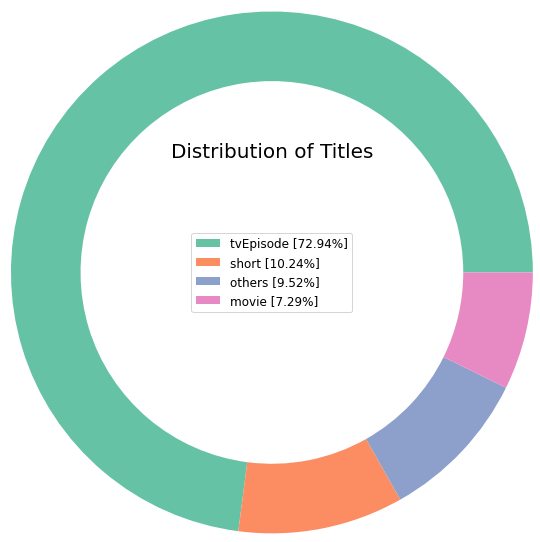

In [ ]:
#https://stackoverflow.com/questions/21034830/how-can-i-generate-more-colors-on-pie-chart-matplotlib
from matplotlib import cm
cs=cm.Set2(np.arange(100))
f=plt.figure()

plt.pie(schema['COUNT'],labeldistance=1,radius=3,colors=cs,wedgeprops=dict(width=0.8))
plt.legend(labels=labels,loc='center',prop={'size':12})
plt.title("Distribution of Titles",loc='Center',fontdict={'fontsize':20,'fontweight':20})

plt.show()


* We see here that TV episodes make up the majority of titles on imdb. 
* Movies, which we will be exploring further make only 7.29% of the dataset. 
* Others category includes titles like TV mini-series, TV shorts, video game etc. 




## Number of titles in each genre

In [ ]:
query= '''
          SELECT genres, COUNT(*) FROM titles 
          WHERE type='movie'
          GROUP BY genres
         ''' 
schema = pd.read_sql_query(query,conn)
display(schema)

,genres,COUNT(*)
0,Action,13172
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1436,"Thriller,Western",35
1437,War,1247
1438,"War,Western",9
1439,Western,4070


In [ ]:
schema['genres']=schema['genres'].str.lower().values
temp = schema['genres'].dropna()

vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
bag_of_genres = vec.transform(temp)
unique_genres =  vec.get_feature_names()


In [ ]:
def return_genres(schema):
  #Source: https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
  schema['genres']=schema['genres'].str.lower().values
  temp = schema['genres'].dropna()
  vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
  unique_genres =  vec.get_feature_names()
  unique_genres=[genre for genre in unique_genres if len(genre)>1 ]
  return unique_genres

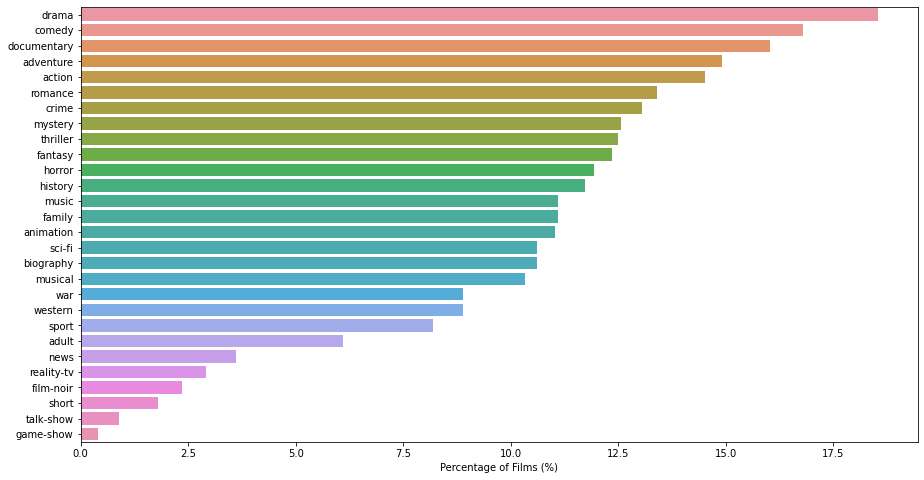

In [ ]:
genres = pd.DataFrame(bag_of_genres.todense(),columns=unique_genres,index=temp.index)
genres=genres.drop(columns='n',axis=0)
sorted_genres_perc = 100*pd.Series(genres.sum()).sort_values(ascending=False)/genres.shape[0]
plt.figure(figsize=(15,8))
sns.barplot(x=sorted_genres_perc.values,y=sorted_genres_perc.index,orient="h")
plt.xlabel("Percentage of Films (%)")
plt.show()


*   Since we have a number of genres for each movie, the total of this graph can add to more than 100%. 
*   We used Countvectorizer to convert genres column into one hot encoded vector in order to count the number of movies in each genre.



## Median Rating per genre

In [ ]:
query= '''
          SELECT rating, genres FROM 
          ratings JOIN titles ON ratings.title_id=titles.title_id 
          WHERE premiered<=2021 AND type='movie'
          
         ''' 
schema = pd.read_sql_query(query,conn)

In [ ]:
def return_genres(schema):
  #Source: https://medium.com/analytics-vidhya/exploratory-data-analysis-imdb-dataset-cff0c3991ad5
  schema['genres']=schema['genres'].str.lower().values
  temp = schema['genres'].dropna()
  vec = CountVectorizer(token_pattern='(?u)\\b[\\w-]+\\b', analyzer='word').fit(temp)
  unique_genres =  vec.get_feature_names()
  unique_genres=[genre for genre in unique_genres if len(genre)>1 ]
  return unique_genres

unique_genres=return_genres(schema)

In [ ]:
genre_counts=[]
genre_ratings=[]
for word in unique_genres:
  query='SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+word+'%'+'\' AND type=\'movie\''
  schema = pd.read_sql_query(query,conn)
  genre_counts.append(schema.values[0][0])
  
  query='SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+word+'%'+'\' AND type=\'movie\''
  schema = pd.read_sql_query(query,conn)
  genre_ratings.append(np.median(schema['rating']))

In [ ]:
genre_rating_df=pd.DataFrame()
genre_rating_df['genres']=unique_genres
genre_rating_df['count']=genre_counts
genre_rating_df['rating']=genre_ratings

In [ ]:
genre_rating_df=genre_rating_df.drop(index=18)
#Drop genre 'n'

In [ ]:
genre_rating_df=genre_rating_df.sort_values(by='rating',ascending=False)

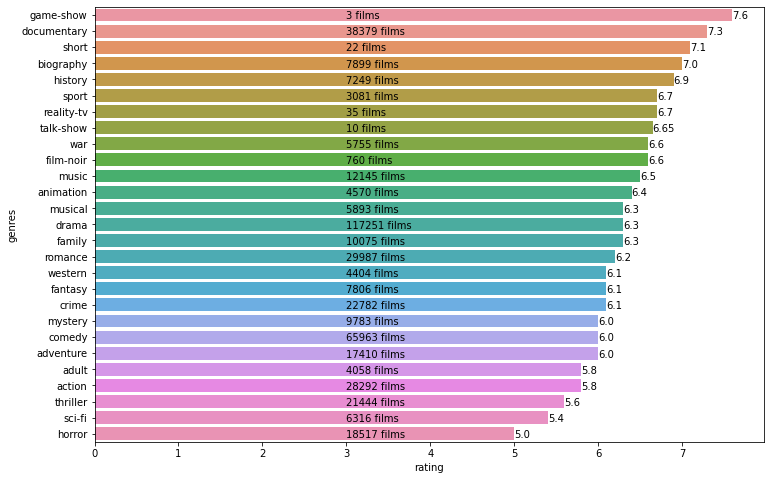

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(y=genre_rating_df.genres,x=genre_rating_df.rating,orient="h")

for i in range(len(genre_rating_df.index)):
    plt.text(3.0,i+0.25,str(genre_rating_df['count'][genre_rating_df.index[i]])+" films")
    plt.text(genre_rating_df.rating[genre_rating_df.index[i]],i+0.25,round(genre_rating_df["rating"][genre_rating_df.index[i]],2))

plt.show()

## Median Ratings over the years

In [ ]:
query= '''
          SELECT rating AS Rating,premiered FROM 
          ratings JOIN titles ON ratings.title_id=titles.title_id 
          WHERE premiered<=2021 AND type='movie'
          ORDER BY premiered
         ''' 
schema = pd.read_sql_query(query,conn)
display(schema)

,Rating,premiered
0,6.4,1896
1,4.5,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
263916,5.3,2021
263917,6.1,2021
263918,8.5,2021
263919,4.8,2021


In [ ]:
ratings=[]
for year in set(schema['premiered']):
  ratings.append(np.median(schema[schema['premiered']==year]['Rating']))

In [ ]:
years=list(set(schema['premiered']))

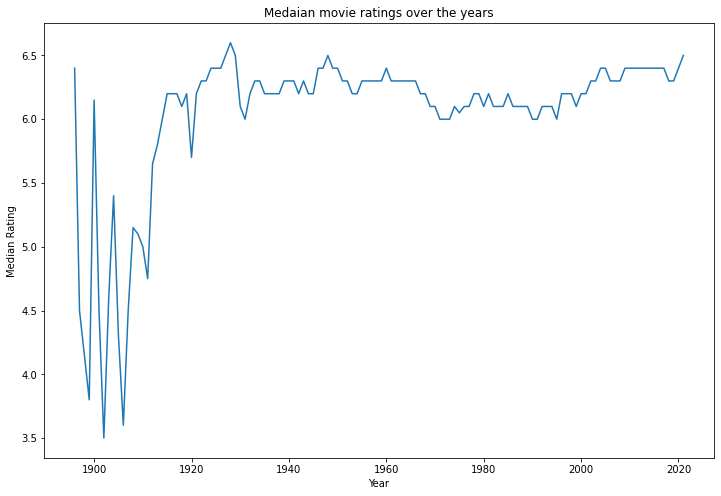

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(years,ratings)
plt.xlabel('Year')
plt.ylabel('Median Rating')
plt.title('Medaian movie ratings over the years')
plt.show()

## Number of films over the years

In [ ]:
query= '''
          SELECT genres FROM titles 
          
      ''' 
schema = pd.read_sql_query(query,conn)

In [ ]:
unique_genres=return_genres(schema)

In [ ]:
genre_count=[]
for word in unique_genres:
  query='SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+word+'%'+'\' AND type=\'movie\' AND premiered <=2021'
  
  schema = pd.read_sql_query(query,conn)

  genre_count.append(schema['COUNT'].values[0])

In [ ]:
genre_count_df=pd.DataFrame()
genre_count_df['genre']=unique_genres
genre_count_df['Count']=genre_count

In [ ]:
genre_count_df=genre_count_df[genre_count_df['genre']!='n']
genre_count_df=genre_count_df.sort_values(by='Count',ascending=False)
top_genres=genre_count_df.head()['genre'].values #Top 5 genres according to movie count

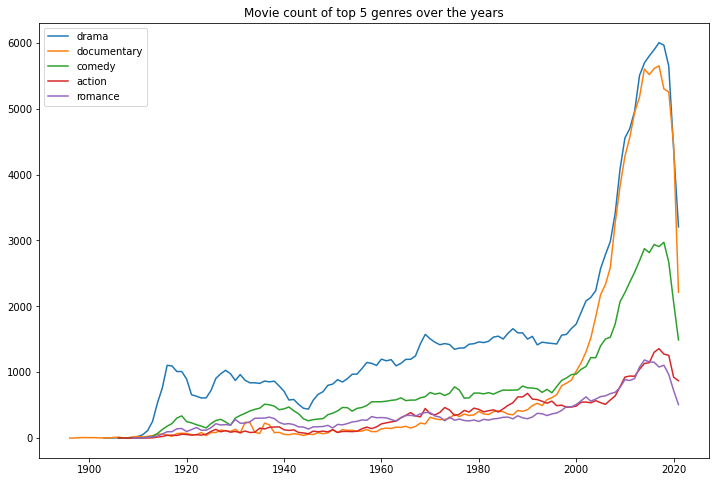

In [ ]:
#genre_counts=[]
#genre_count=[]
plt.figure(figsize=(12,8))
for word in top_genres:
  query='SELECT COUNT(*) Number_of_movies,premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+word+'%'+'\' AND type=\'movie\' AND Year <=2021 GROUP BY Year'
  
  schema = pd.read_sql_query(query,conn)
  plt.plot(schema['Year'],schema['Number_of_movies'])
  #if schema[schema['Number_of_movies']==0].shape[0]==0: break
  #genre_count.append(schema['COUNT'].values[0])

plt.title('Movie count of top 5 genres over the years')
plt.legend(labels=top_genres)
plt.show()

## Runtime distribution and outlier removal

In [ ]:
query= '''
          SELECT runtime_minutes Runtime 
          FROM titles 
          WHERE type='movie' AND Runtime!='NaN'
          
         ''' 
schema = pd.read_sql_query(query,conn)

In [ ]:
for i in range(11): 
  val=99+i/10
  perc=round(np.percentile(schema['Runtime'].values, val),2)
  print('{} percentile value of runtime is: {}'.format(val,perc))

99.0 percentile value of runtime is: 168.0
99.1 percentile value of runtime is: 170.0
99.2 percentile value of runtime is: 174.0
99.3 percentile value of runtime is: 178.0
99.4 percentile value of runtime is: 180.0
99.5 percentile value of runtime is: 186.0
99.6 percentile value of runtime is: 198.0
99.7 percentile value of runtime is: 213.49
99.8 percentile value of runtime is: 240.0
99.9 percentile value of runtime is: 300.0
100.0 percentile value of runtime is: 51420.0


Put threshold of 300 minutes on runtime to remove outliers.

Cheking outliers: Longest film ever made

In [ ]:
query= '''
          SELECT runtime_minutes Runtime, primary_title
          FROM titles 
          WHERE type='movie' AND Runtime!='NaN'
          ORDER BY Runtime DESC
          LIMIT 1
          
         ''' 
schema = pd.read_sql_query(query,conn)

In [ ]:
schema

,Runtime,primary_title
0,51420,Logistics


'Logistics' is the longest movie ever made at 857 days. Directed by 
Daniel Andersson and Erika Magnusson, the movie tracks the whole life cycle of a pedometer (steps tracking device) in reverse chronological order. 

Histogram of runtime

In [ ]:
x=schema['Runtime'][schema.Runtime<300]

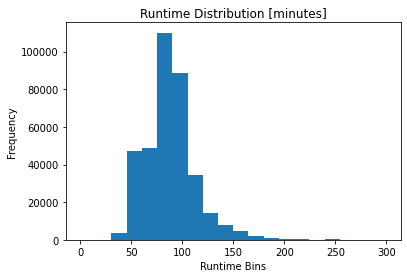

In [ ]:
plt.hist(x,bins=20)
plt.xlabel('Runtime Bins')
plt.ylabel('Frequency')
plt.title('Runtime Distribution [minutes]')
plt.show()

From the above graph we can see that the most common runtime for movies is between 80 to 100 minutes.

## Runtime vs Genre

In [ ]:
query= '''
          SELECT AVG(runtime_minutes) Runtime,genres 
          FROM titles 
          WHERE type='movie'
          AND runtime_minutes!='NaN'
          GROUP BY genres
          
         ''' 
schema = pd.read_sql_query(query,conn)


In [ ]:
unique_genres=return_genres(schema)

In [ ]:
#genre_counts=[]
genre_runtime=[]
for word in unique_genres:
  query='SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+word+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
  schema = pd.read_sql_query(query,conn)
  genre_runtime.append(np.median(schema['Runtime']))

In [ ]:
genre_runtime_df=pd.DataFrame()
genre_runtime_df['genre']=unique_genres
genre_runtime_df['runtime']=genre_runtime

In [ ]:
genre_runtime_df=genre_runtime_df.drop(index=18)

In [ ]:
genre_runtime_sorted=genre_runtime_df.sort_values(by='runtime',ascending=False)

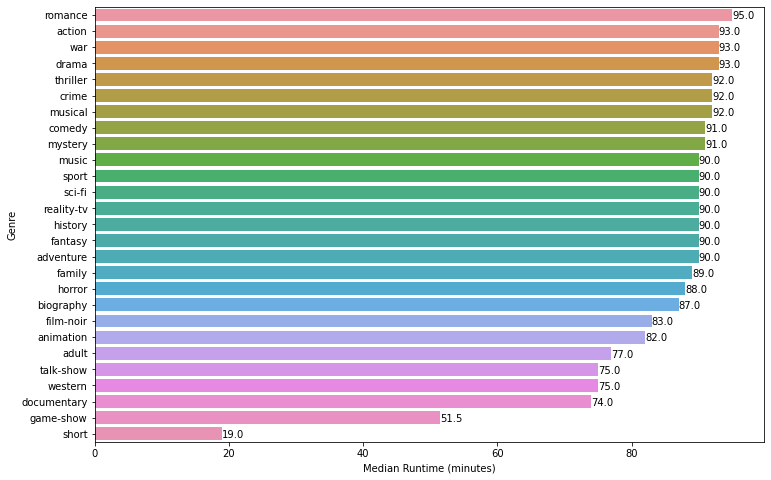

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(y=genre_runtime_sorted.genre,x=genre_runtime_sorted.runtime,orient="h")

for i in range(len(genre_runtime_sorted.index)):
    #plt.text(3.0,i+0.25,str(genre_rating_df['count'][genre_rating_df.index[i]])+" films")
    plt.text(genre_runtime_sorted.runtime[genre_runtime_sorted.index[i]],i+0.25,
             round(genre_runtime_sorted["runtime"][genre_runtime_sorted.index[i]],2))

plt.ylabel('Genre')             
plt.xlabel('Median Runtime (minutes)')
plt.show()

## Country vs Number of Movies

In [ ]:
query= '''
          SELECT region,COUNT(*) Number_of_movies FROM 
          akas JOIN titles ON 
          akas.title_id=titles.title_id
          WHERE region!='None'
          AND type=\'movie\'
          GROUP BY region
          
          
         ''' 
schema = pd.read_sql_query(query,conn)
display(schema)

,region,Number_of_movies
0,AD,21
1,AE,335
2,AF,108
3,AG,12
4,AL,1226
...,...,...
227,YUCS,146
228,ZA,2832
229,ZM,11
230,ZRCD,2


In [ ]:
!pip3 install pycountry

     |████████████████████████████████| 10.1MB 6.9MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=a0078909974388dd89c4eaa971969721d4600e51a9f59b7f357a0fc33879cd25
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
import pycountry

In [ ]:
country_names=[]
count=[]
for i in range(schema.shape[0]):
  try:
    coun=schema['region'].values[i]
    country_names.append(pycountry.countries.get(alpha_2=coun).name)
    count.append(schema['Number_of_movies'].values[i])
  except: 
    continue
#counts = country_counts.drop(["XWW","XWG"]).values[:20]

In [ ]:
country_movies_df=pd.DataFrame()
country_movies_df['country']=country_names
country_movies_df['Movie_Count']=count

In [ ]:
country_movies_sorted=country_movies_df.sort_values(by='Movie_Count',ascending=False)

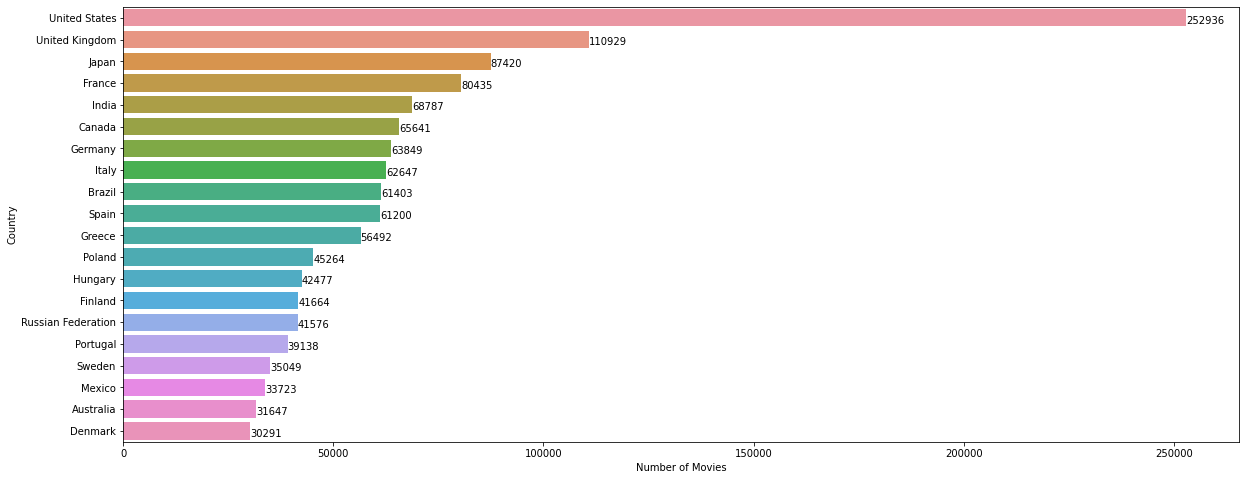

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(y=country_movies_sorted[:20].country,x=country_movies_sorted[:20].Movie_Count,orient="h")

for i in range(0,20):
    #plt.text(3.0,i+0.25,str(genre_rating_df['count'][genre_rating_df.index[i]])+" films")
    plt.text(country_movies_sorted.Movie_Count[country_movies_sorted.index[i]]-1,i+0.25,
             round(country_movies_sorted["Movie_Count"][country_movies_sorted.index[i]],2))

plt.ylabel('Country')             
plt.xlabel('Number of Movies')
plt.show()

## Top 10 best and worst movies

In [ ]:
query= '''
          SELECT primary_title AS Movie_Name,genres,rating
          FROM 
          titles JOIN ratings
          ON  titles.title_id=ratings.title_id
          WHERE titles.type='movie' AND ratings.votes>=25000
          ORDER BY rating DESC
          LIMIT 10
          
         ''' 
top10_movies = pd.read_sql_query(query,conn)
display(top10_movies)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


In [ ]:
query= '''
          SELECT primary_title AS Movie_Name,genres,rating
          FROM 
          titles JOIN ratings
          ON  titles.title_id=ratings.title_id
          WHERE titles.type='movie' AND ratings.votes>=25000
          ORDER BY rating ASC
          LIMIT 10
          
         ''' 
worst10_movies = pd.read_sql_query(query,conn)
display(worst10_movies)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,Horror,1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9


Funnily enough, Radhe got a spot in the bottom 10 rated movies already!